# Resolution parameter

**Community detection** is a crucial task in network science focused on finding groups of nodes (called communities or modules) that are more densely connected to each other than to the rest of the network. This process is vital for understanding the underlying structure of complex systems, from social networks to biological interaction maps.

A popular class of algorithms for this task, including the well-known Louvain method, operates by **maximizing a quality metric called modularity**. 

However, these methods suffer from a major limitation known as the **resolution limit**. This problem arises because maximizing modularity often favors merging small, distinct communities into larger clusters, especially in big networks. This can lead to a loss of important, fine-grained structural information. The algorithm essentially has a "preference" for a particular community scale and cannot reliably detect communities that are smaller than this scale.

In this notebook, we will cover the concept of **resolution parmater** and demonstrate the **resolution limit** problem using a synthetic network. We will show how a standard modularity-based algorithm fails to identify the correct community structure. We will then introduce **multiresolution methods** and the use of the `resolution` parameter to overcome this limitation, allowing us to find communities at different scales and reveal the true structure of the network.

In [1]:
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import random
from itertools import combinations
ig.config["plotting.backend"] = "matplotlib"
pyo.init_notebook_mode(connected=True)

In [2]:
# We import the sierpinski_graph() function from this notebook
%run -i functions.ipynb

## Sierpiński

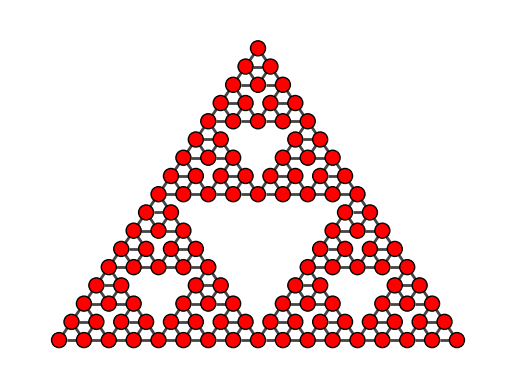

In [3]:
g = sierpinski_graph(4)
g.vs['size'] = 15 # store vertex sizes in the graph
ig.plot(g);

Clustering with 123 elements and 9 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
[1] 14, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40
[2] 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27
[3] 41, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96
[4] 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55
[5] 49, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68
[6] 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82
[7] 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108
[8] 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122


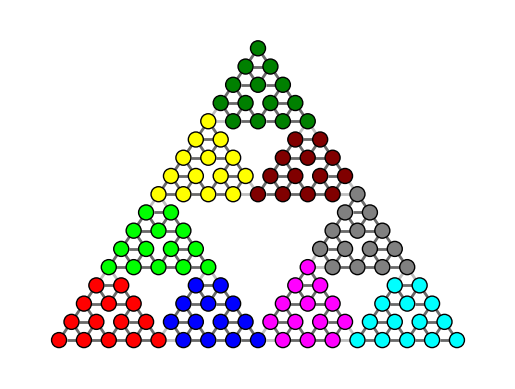

In [4]:
comms = g.community_leiden(objective_function="modularity") # in this case the default resolution = 1
print(comms)
ig.plot(comms);

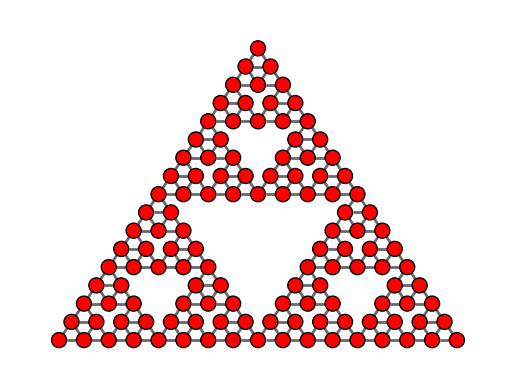

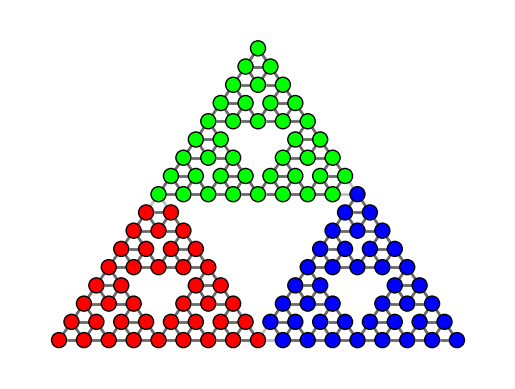

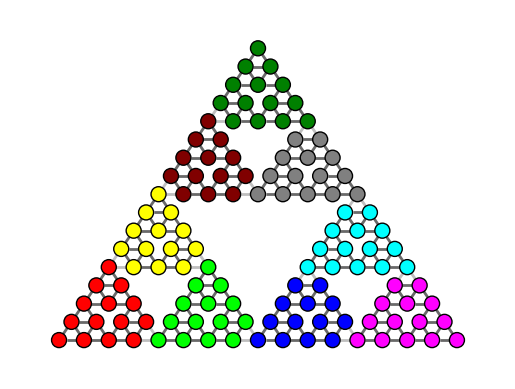

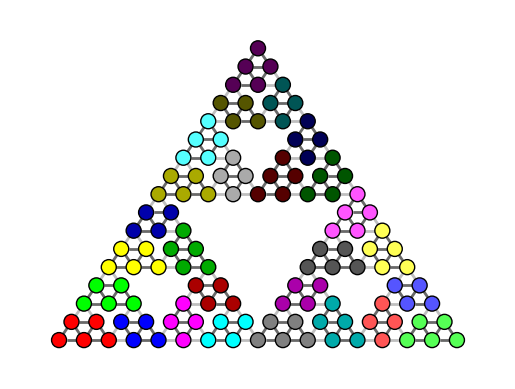

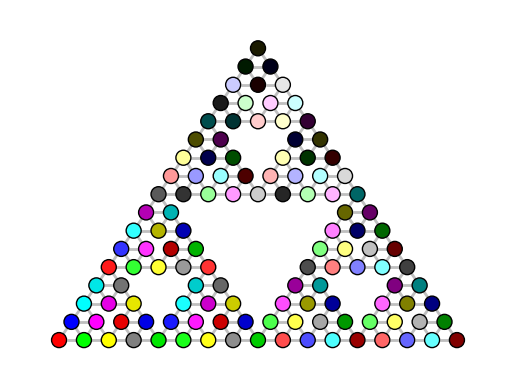

In [5]:
for gamma in np.logspace(-2,2, 5):
    comm = g.community_leiden(objective_function="modularity", resolution = gamma)
    ig.plot(comm)
    plt.show()

The above images illustrate how the **resolution parameter** in the Leiden community detection algorithm affects the number and size of communities found in a *Sierpinski graph*.

---

The resolution parameter acts as a control knob for the granularity of community detection. A lower value yields fewer, larger communities, while a higher value results in more numerous, smaller communities. This demonstrates the hierarchical nature of the Sierpinski graph, where communities can be detected at different scales depending on the chosen resolution.

But how do we find the 'right' resolution? There is a method to identify values that generate relatively stable communities. The idea is to test a range of resolution parameters with small steps, count the number of communities, and calculate the percentage of internal edges, then plot these results on a log scale:

In [6]:
def resolution_profile(g, weights=None):
    resolutions = np.logspace(-2, 2, 500)
    community_count = []
    external_edges_fraction = []
    for gamma in resolutions:
        comms = g.community_leiden(objective_function="modularity", resolution=gamma, weights=weights)
        community_count.append(len(comms))
        external_edges_fraction.append( 1 - g.modularity(comms.membership, resolution=0, weights=weights))
    return resolutions, community_count, external_edges_fraction
    
resolutions, community_count, external_edges_fraction = resolution_profile(g)

<div style="background-color: #e6ffe6; border-radius: 5px;">
    
_Note:_ In the **modularity formula** introduced [here](./modularity.ipynb), we saw the appearance of the resolution parameter ($\gamma$). If we take a closer look at the formula we can easily see that when the resolution ($\gamma$) equals to $0$, the formula gives us the fraction of *internal edges* in the community. So by calculating the $1 - modularity$ (with $\gamma = 0$) we can get the fraction of *external edges*.

</div>

In [7]:
fig = px.line(x=resolutions, y=community_count, log_x=True, log_y=True, labels={'x': 'Resolution', 'y': 'Community Count'})
pyo.iplot(fig)

In [8]:
fig = px.line(x=resolutions, y=external_edges_fraction, log_x=True, log_y=True, labels={'x': 'Resolution', 'y': 'External Edges Fraction'})
pyo.iplot(fig)

The plateaus in the first plot indicate regions where the number of communities remains constant despite changes in the resolution parameter. These stable regions are often considered good candidates for the "correct" resolution. The same principle can be applied to the second plot. If we take a closer look at the plots, we can observe that these plateaus are almost within the same x range.

By analyzing these plots, we can choose resolution values that generate stable communities and that therefore will be considered "good" values for detecting communities.

We can try the same approach on defferent graphs:

## Stochastic Block Model

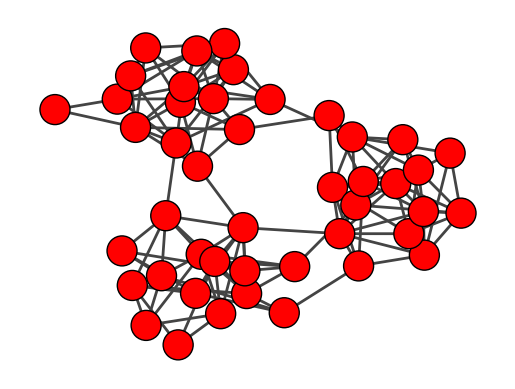

In [9]:
# Define the parameters for the SBM
num_blocks = 3  # Number of communities
block_sizes = [15, 15, 15]  # Number of vertices in each block
num_vertices = sum(block_sizes) # Total number of vertices

p_in = 0.5  # Probability of an edge within a block
p_out = 0.01  # Probability of an edge between blocks

pref_matrix = [
    [p_in, p_out, p_out],
    [p_out, p_in, p_out],
    [p_out, p_out, p_in],
]

g = ig.Graph.SBM(
    n=num_vertices,
    pref_matrix=pref_matrix,
    block_sizes=block_sizes
)

ig.plot(g);

In [10]:
resolutions, community_count, external_edges_fraction = resolution_profile(g)

In [11]:
fig = px.line(x=resolutions, y=community_count, log_x=True, log_y=True, labels={'x': 'Resolution', 'y': 'Community Count'})
pyo.iplot(fig)

In [12]:
fig = px.line(x=resolutions, y=external_edges_fraction, log_x=True, log_y=True, labels={'x': 'Resolution', 'y': 'External Edges Fraction'})
pyo.iplot(fig)

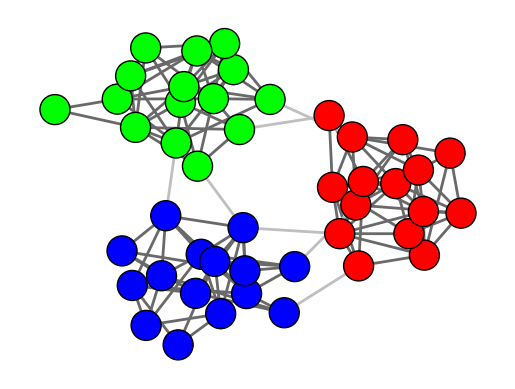

In [13]:
comms = g.community_leiden(objective_function="modularity", resolution = 0.5)
ig.plot(comms);

_Note:_ We can see that the biggest and main plateau is around $0.1$ and $1.6$ (this is why in the clustering we've chosen the $0.5$ as out resoltution parameter value). This plateau corresponds to $3$ generated clusters, which was our main assumption, since we generated the graph to have that exact amount of communities.

## Game of Thrones

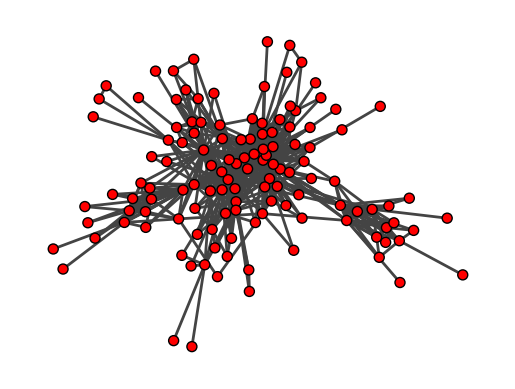

In [14]:
g = ig.Graph.Read_GraphML("../networks/game_of_thrones/GoT.graphml")
g.vs['size'] = 10
ig.plot(g, layout=g.layout("fr"));

In [15]:
resolutions, community_count, external_edges_fraction = resolution_profile(g, weights='weight')

In [16]:
fig = px.line(x=resolutions, y=community_count, log_x=True, log_y=True, labels={'x': 'Resolution', 'y': 'Community Count'})
pyo.iplot(fig)

In [17]:
fig = px.line(x=resolutions, y=external_edges_fraction, log_x=True, log_y=True, labels={'x': 'Resolution', 'y': 'External Edges Fraction'})
pyo.iplot(fig)

_Note:_ Three main plateaus were observed in this case, indicating stable clustering solutions at various resolutions. A resolution parameter of $0.45$ offers a distinct and well-defined clustering. This is a good value to test for a clear grouping of the data points.

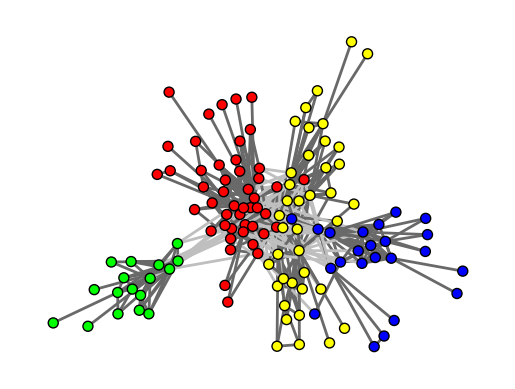

In [18]:
comms = g.community_leiden(objective_function="modularity", resolution=0.45, weights='weight')
ig.plot(comms);

## The resolution limit problem in community detection

The **resolution limit** is a well-known problem in community detection, particularly for algorithms that aim to maximize a single metric like modularity. It refers to the inability of these algorithms to detect small, well-defined communities within a large network.

This issue was famously highlighted in the seminal work by Fortunato and Barthélemy, ["Resolution limit in community detection"](https://arxiv.org/abs/physics/0607100). They demonstrated that the algorithm may find that merging two or more small communities results in a higher overall modularity score than keeping them separate, especially as the size of the overall network increases.

---

### Demonstrating the problem with a synthetic graph

To see this problem in action, we can create a synthetic graph with many small, dense communities. A modularity-based algorithm should ideally find these small communities, but because of the resolution limit, it will often merge them into fewer, larger clusters.

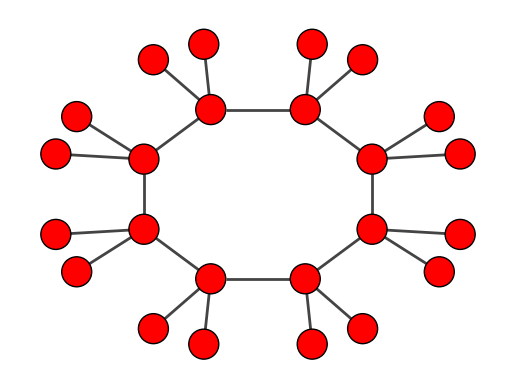

In [19]:
g = ig.Graph.Ring(n=8)

for i in range(8):
    current_v_count = g.vcount()
    g.add_vertices(2)
    g.add_edges([(i, current_v_count), (i, current_v_count + 1)])

layout = g.layout_kamada_kawai()
ig.plot(g, layout=layout);

#### Applying a standard modularity-based algorithm

Now, we'll use igraph's implementation of the Louvain method (community_multilevel) without adjusting any parameters. This algorithm aims to maximize modularity.

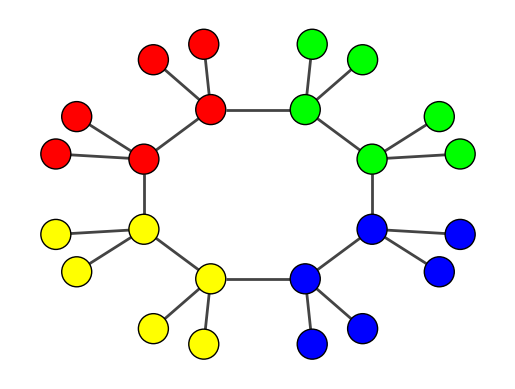

In [20]:
communities = g.community_multilevel()
membership = communities.membership
palette = ig.ClusterColoringPalette(len(communities))
ig.plot(g, layout=layout, vertex_color=[palette[c] for c in membership]);

As we can see from the output and the plot, the algorithm incorrectly identifies the communities, despite the clear separation in the graph's structure. This is a direct example of the resolution limit.

#### Overcoming the resolution limit with a resolution parameter

To overcome this limitation, we can use a multiresolution method. The `community_multilevel` function in `igraph` includes a resolution parameter.

- A resolution value of 1.0 (the default) corresponds to standard modularity maximization.

- A value less than 1.0 will favor finding fewer, larger communities.

- A value greater than 1.0 will favor finding more, smaller communities.

By increasing the resolution parameter, we can force the algorithm to be more sensitive to smaller communities.

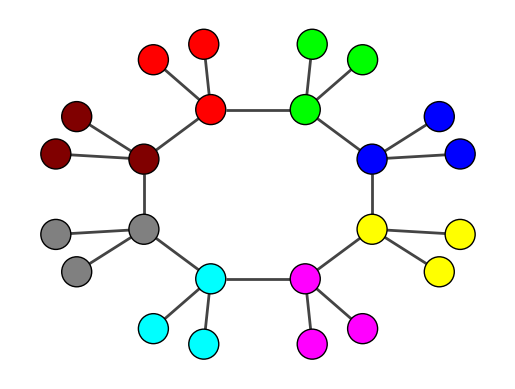

In [21]:
communities = g.community_multilevel(resolution=1.5)
membership = communities.membership
palette = ig.ClusterColoringPalette(len(communities))
ig.plot(g, layout=layout, vertex_color=[palette[c] for c in membership]);